# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

In [ ]:
# { импорт данных }

import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv")

In [ ]:
# { написанные функции }
import numpy as np

def onehot_encoding(x: np.ndarray) -> np.ndarray:
    sorted_types = sorted(list(set(x)))
    hot = []

    for i in x:
        row = []
        for j in sorted_types:
            if j == i:
                row.append(1)
            else:
                row.append(0)
        hot.append(row)

    return np.array(hot)

def minmax_scale(X: np.ndarray) -> np.ndarray:
    data_min = X.min(axis=0)
    data_max = X.max(axis=0)

    scale = data_max - data_min
    scale[scale == 0] = 1

    return (X - data_min) / scale

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [ ]:
data['Gender'].isna().sum() / data.shape[0] # больше 70% значений в Gender пропущено, дропну колонку

# пробовал ее оставить, рассуждения такие были: хотя и много пропусков, но мы делаем downsampling, удаляя большую часть данных, а значит и особо
# ничего не изменится (да, дропая пропуски мы остаемся без части данных, но тут это имеет смысл из за downsampling)
# я пробовал оставить Gender, но на тестовой выборке я получил метрики хуже, чем с dropna, поэтому принял решение избавиться полностью от фичи

0.7122982661150239

In [ ]:
data.drop(columns=['Gender'], inplace=True)

In [ ]:
# { кодирование и скейлинг буду применять после анализа }

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели.

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

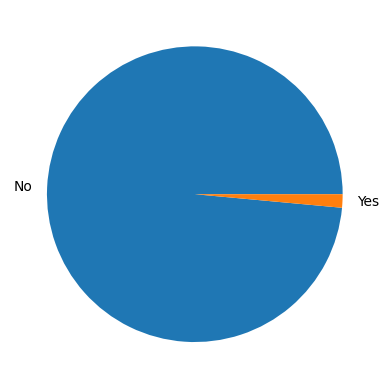

In [ ]:
import matplotlib.pyplot as plt

plt.pie(data['Claim'].value_counts(), labels=data['Claim'].value_counts().index)
plt.show()

# наблюдаем сильный дизбаланс таргета, будем проводить downsampling

In [ ]:
data['Claim'] = np.where(data['Claim'] == 'Yes', 1, 0)
data['Agency Type'] = np.where(data['Agency Type'] == 'Airlines', 1, 0)
data['Distribution Channel'] = np.where(data['Distribution Channel'] == 'Online', 1, 0)

# переведем бинарные фичи в int

In [ ]:
# 1. проанадизируем значения детально, чтобы выявить аномалии

# в Duration есть значения < 0, сомнительно, но можем предположить, что поездка еще не состоялась (не буду удалять)
# data['Duration'].sort_values().head(10)

# я пытался с помощью GPT сгруппировать страны на развитые, развивающиеся и бедные, но он не смог, а вручную долго. Просто удалю
data.drop(columns=['Destination'], inplace=True)

# Age, Net Sales, Commision проанализировал, там нет каких то аномальных значений

# Есть идеи насчет Agency: можно как то погуглить и разделить компании по разным категориям (пусть по тому в какой стране зарегистрировано агентство или
# насколько давно было зарегистрировано агентство), но я удалю (ибо если кодировать без группировки размерность сильно раздувается, у нас и так после
# downsampling останется мало записей)

# В Product name в названиях есть слова Silver, Platinum и тд. Можно сгруппировать по премиальности продукта (пробовал, получил метрики хуже)
# data.drop(columns=['Product Name'], inplace=True)


In [ ]:
data.drop(columns=['Agency'], inplace=True)

In [ ]:
def name_group(name) -> np.ndarray:
    if 'comprehensive' in name.lower():
        return 'comprehensive'
    elif 'basic' in name.lower() or 'bronze' in name.lower():
        return 'low'
    elif 'silver' in name.lower():
        return 'mid'
    elif 'gold' in name.lower() or 'platinum' in name.lower() or 'premier' in name.lower():
        return 'high'
    return 'other'

# пробовал с группировкой и ohe, но метрики получил хуже

In [ ]:
# data['Product Name'] = data['Product Name'].apply(lambda x: name_group(x)) отказался от этой идеи

In [ ]:
# data = pd.concat([data, pd.DataFrame(onehot_encoding(np.array(data['Product Name'])))], axis=1) отказался
data.drop(columns=['Product Name'], inplace=True)

In [ ]:
# я бы разделял данные сразу, чтобы избежать возможных утечек данных, но требуется применить свой minmax scale, который возвращает np.array, с которым
# неудобно проводить анализ данных, поэтому разделил только сейчас
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = minmax_scale(np.array(data.drop(columns=['Claim'])))  # применю здесь свой minmax_scale (хотя я бы использовал встроенный и засунул бы его в пайплайн)
y = np.array(data['Claim'].copy())

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y) # downsampling

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=42)

X_train_nodown, X_test_nodown, y_train_nodown, y_test_nodown = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2.

In [ ]:
# посчитайте аналитическое решение
lambda_ = 1  # Коэффициент регуляризации

# Добавляем столбец единиц для свободного члена
X_new = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

# Здесь регуляризация применяется ко всем коэффициентам (в том числе и к свободному члену)

analyt = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y_train # при ohe я получил ошибку singular matrix, так как мной написанный метод не учитывает
# возникновение мультиколлиниарности (не инверитруемая матрица), хотя можно вручную удалить один из столбцов ohe

In [ ]:
# посчитать аналитическое решение с регуляризацией
analyt_ridge = np.linalg.inv(X_new.T @ X_new + lambda_ * np.eye(X_new.shape[1])) @ X_new.T @ y_train

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train)
reg_ridge = Ridge().fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_ridge = reg_ridge.predict(X_test)
y_pred_ridge_nodown = reg_ridge.predict(X_test_nodown)  # посмотрим на большем размере выборки


In [ ]:
from sklearn.preprocessing import minmax_scale

y_pred_scaled = minmax_scale(y_pred_ridge)
y_pred_bin = np.array([0 if x < 0.2 else 1 for x in y_pred_scaled]) # при таком пороге, получаю лучшие метрики на test

y_pred_scaled_nodown = minmax_scale(y_pred_ridge_nodown)
y_pred_bin_nodown = np.array([0 if x < 0.2 else 1 for x in y_pred_scaled_nodown])

In [ ]:
print(mean_squared_error(y_test, y_pred_bin))
print(mean_squared_error(y_test_nodown, y_pred_bin_nodown))

0.2875816993464052
0.31969566465690497


In [ ]:
len(y_pred_bin_nodown)

20898

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# в этой задаче важнее всего метрика recall, так как нам важна полнота, то есть если отметим claim единицей ошибочно (потребовалась страховка), то ничего
# старшного, ведь мы можем, допустим, позвонить человеку и уточнить, а если вот пропустим человека, которому действительно потребовалась страховка
# (случилось что то неприятное), то это плохо
print('=====Возьмем тестовую из resampled=====')
print(f"accuracy: {accuracy_score(y_test, y_pred_bin)}")  # без downsampling получаем accuracy близкий к 1, но f1 близкий к нулю из за дизбаланса классов
print(f"f1: {f1_score(y_test, y_pred_bin)}")
print(f"recall: {recall_score(y_test, y_pred_bin)}")
print(f"precision: {precision_score(y_test, y_pred_bin)}")
print('=====Возьмем тестовую из изначального датасета=====')
print(f"accuracy: {accuracy_score(y_test_nodown, y_pred_bin_nodown)}")
print(f"f1: {f1_score(y_test_nodown, y_pred_bin_nodown)}")
print(f"recall: {recall_score(y_test_nodown, y_pred_bin_nodown)}")
print(f"precision: {precision_score(y_test_nodown, y_pred_bin_nodown)}")

=====Возьмем тестовую из resampled=====
accuracy: 0.7124183006535948
f1: 0.7188498402555911
recall: 0.7352941176470589
precision: 0.703125
=====Возьмем тестовую из изначального датасета=====
accuracy: 0.680304335343095
f1: 0.06336744707696622
recall: 0.7197452229299363
precision: 0.0331426895439214


In [ ]:
# можно наблюдать как метрика precision стремится к нулю: это происходит из за того, что в изначальном датасете сильный перевес в пользу true negatives
# а обучалась модель на сбалансированном маленьком датасете, из за чего модель хоть и с хорошей точностью определяет положительный класс (recall), но на
# негативных классах она сильно хромает, но нам важно было получить хороший recall, так что справилась модель хорошо при наших условиях

# можно предположить, что модель теперь втупую ставит единички на большей части датасета, но это опровергается достаточно высоким accuracy (хотя если
# поменять порог приравнивания к нулю и единице таргета, recall может вырасти, но accuracy сильно упадет или наоборот, так что я выбрал золотую середину)

### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

Я считаю, я хорошо справился с задачей линейной регрессии, выбрал оптимальный способ предобработки данных и добился хорошего значения метрики recall при таком объеме данных (<2000 записей из за дизбаланса классов)